In [1]:
# !pip3 install memory_profiler opencv-python numpy matplotlib scikit-image

# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import skimage.color
import skimage.filters
import skimage.io
import skimage.feature
import skimage.measure
import skimage.color

from textureTransfer import Construct as transfer_texture
%matplotlib inline
%load_ext memory_profiler

# Utility functions

In [2]:
# Scaling or clipping
scale = lambda x, top=255: (top * (x - np.min(x))) / (np.max(x) - np.min(x))
inrange = lambda x: np.where(x > 255, 255, np.where(x < 0, 0, x))
invert = lambda x: np.max(x) - x
print_range = lambda x: print(np.min(x), np.max(x))

run_tests = False

# Image input and pre processing

In [3]:
prewitt = [np.array(
               [[-1, 0, 1],
                [-1, 0, 1],
                [-1, 0, 1]]), 
           np.array(
               [[ 1,  1,  1],
                [ 0,  0,  0],
                [-1, -1, -1]])]

def apply_filter(im, filt, zero_padding=False):
    
    wdth = filt.shape[0]//2
    
    filt_img = np.zeros(im.shape)
    
    if zero_padding:
        im = np.vstack( (np.zeros( (wdth, im.shape[1]) ), im, np.zeros( (wdth, im.shape[1]) ) ) )
        im = np.hstack( (np.zeros( (im.shape[0], wdth) ), im, np.zeros( (im.shape[0], wdth) ) ) )
    else:
        im = np.vstack(([im[0]]*wdth, im, [im[-1]]*wdth))
        im = np.hstack((np.hstack([im[:,0].reshape(-1,1)]*wdth), im, np.hstack([im[:,-1].reshape(-1,1)]*wdth)))

    for i in range(wdth, im.shape[0]-wdth):
        for j in range(wdth, im.shape[1]-wdth):
            filt_img[i-wdth][j-wdth] = np.sum(im[i-wdth:i+wdth+1, j-wdth:j+wdth+1] * filt)
    
    return np.rint(filt_img)

In [4]:
def decouple(img, type=0):
    
    img = img.astype('float64')
    
    with np.errstate(divide='ignore', invalid='ignore'):
        intensity_layer = np.nan_to_num(np.true_divide(((img[:, :, 0]**2) + (img[:, :, 1]**2) + (img[:, :, 2]**2)) , (img[:,:,0]+img[:, :, 1]+img[:, :, 2])))
        intensity_layer = np.rint(intensity_layer).astype('uint8')
        
        if type < 2:
            dx = apply_filter(intensity_layer.astype('float64'), prewitt[0])
            dy = apply_filter(intensity_layer.astype('float64'), prewitt[1])
        
            gradient = np.nan_to_num(np.arctan(dy/dx))
        else:
            return intensity_layer
    
    if type == 1:
        return gradient
    return intensity_layer,gradient

# Distance function

In [5]:
def distance(sI, sG, tI, tG):

    M, N = tI.shape
    
    Y, X = sI.shape
    wdth_y, wdth_x = Y//2, X//2

    tI = np.vstack(([tI[0]]*wdth_y, tI, [tI[-1]]*(Y-wdth_y)))
    tI = np.hstack((np.hstack([tI[:,0].reshape(-1,1)]*wdth_x), tI, np.hstack([tI[:,-1].reshape(-1,1)]*(X-wdth_x))))

    tG = np.vstack(([tG[0]]*wdth_y, tG, [tG[-1]]*(Y-wdth_y)))
    tG = np.hstack((np.hstack([tG[:,0].reshape(-1,1)]*wdth_x), tG, np.hstack([tG[:,-1].reshape(-1,1)]*(X-wdth_x))))
   
    g_img = np.zeros((M, N))
    l_img = np.zeros((M, N))
   
    for i in range(wdth_y, wdth_y+M):
        for j in range(wdth_x, wdth_x+N):
            try:
                g_img[i-wdth_y ,j-wdth_x] = np.average(np.abs(sG - tG[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x]))
                l_img[i-wdth_y ,j-wdth_x] = np.average(np.abs(sI - tI[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x]))
            
            except Exception:
                print("Source shape: ", sG.shape, "  i, j:", i, j, "   Patch shape:",  tG[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x].shape)
                raise Exception
            
    return (g_img / np.max(g_img)) + (l_img / np.max(l_img))

In [6]:
def inbuilt_distance(sI, sG, tI, tG, scalefactor=True):

    M, N = tI.shape
    
    Y, X = sI.shape
    wdth_y, wdth_x = Y//2, X//2
    try:
        if wdth_y:
            tI = np.vstack(([tI[0]]*wdth_y, tI))
            tG = np.vstack(([tG[0]]*wdth_y, tG))
        if Y-wdth_y-1:
            tI = np.vstack((tI, [tI[-1]]*(Y-wdth_y-1)))
            tG = np.vstack((tG, [tG[-1]]*(Y-wdth_y-1)))
        
        if wdth_x:
            tI = np.hstack((np.hstack([ tI[:,0].reshape(-1,1)]*wdth_x), tI))
            tG = np.hstack((np.hstack([tG[:,0].reshape(-1,1)]*wdth_x), tG))
        if X-wdth_x-1:
            tI = np.hstack((tI, np.hstack([tI[:,-1].reshape(-1,1)]*(X-wdth_x-1))))
            tG = np.hstack((tG, np.hstack([tG[:,-1].reshape(-1,1)]*(X-wdth_x-1))))
            
    except Exception:
        print("\n", wdth_x, wdth_y, Y-wdth_y-1, X-wdth_x-1)
        raise Exception   

#     lum = cv2.matchTemplate(tI,sI, cv2.TM_CCOEFF_NORMED)
#     grd = cv2.matchTemplate(np.rint(scale(tG)).astype('uint8'), np.rint(scale(sG)).astype('uint8'), cv2.TM_CCOEFF_NORMED)

    lum = cv2.matchTemplate(tI,sI, cv2.TM_CCOEFF)
    grd = cv2.matchTemplate(np.rint(scale(tG)).astype('uint8'), np.rint(scale(sG)).astype('uint8'), cv2.TM_CCOEFF)

    if scalefactor:
        return scale(invert(lum+grd), 1)
    
    return invert(lum+grd)

In [7]:
def median_filter(im, k):
        
    filt_img = np.zeros(im.shape)

    wdth = k//2

    im = np.vstack(([im[0]]*wdth, im, [im[-1]]*(k-wdth)))
    im = np.hstack((np.hstack([im[:,0].reshape(-1,1)]*wdth), im, np.hstack([im[:,-1].reshape(-1,1)]*(k-wdth))))

    for j in range(wdth, im.shape[1]-wdth):
        for i in range(wdth, im.shape[0]-wdth):
            x = np.median(im[i-wdth:i+k-wdth+1, j-wdth:j+k-wdth+1])
            filt_img[i-wdth][j-wdth] = x
    
    return filt_img

# Age Map function

In [8]:
def age(source_patch, target, K, num_bins=1000):
    
    sI, sG = source_patch
    tI, tG = target
    dist_mat = inbuilt_distance(sI, sG, tI, tG, False)

    ## Method 1
    # discrete = np.rint(scale(dist_mat)).astype('uint8')
    # size = sI.shape[0]//2
    # size = max(1, size + (1-(size%2)))
    # discrete = cv2.medianBlur(discrete, size)

    # K_distances = np.sort(np.unique(discrete).flatten())[:K]
    # co_ords = []
    # for i in K_distances:
    #     x, y = np.where(discrete == i)
    #     for j in zip(x, y):
    #         co_ords.append(j)

    # K_neighbours = [dist_mat[x, y] for (x, y) in co_ords]
    # K_neighbours = [dist_mat[x, y] for (x, y) in co_ords]

    # return np.average(K_neighbours)
    
    ## Method 2
    bins = np.digitize(dist_mat, np.linspace(np.min(dist_mat), np.max(dist_mat), num_bins))
    bins_mapped = np.linspace(np.min(dist_mat), np.max(dist_mat), num_bins)[bins-1]
    vals, counts = np.unique(bins_mapped, return_counts=True)
    cumsum = np.cumsum(counts)
    cumsum = cumsum/cumsum[-1]
    x, = np.argwhere(cumsum > K)[0]

    
    K_distances = vals[:x] * counts[:x]
    K_distances = np.sum(K_distances)/np.sum(counts[:x])

    return K_distances

In [9]:
def generate_age_map(I, G, N, K):

    age_map = np.zeros(I.shape, dtype=('float64'))

    for i in range(0, I.shape[0], N):
        for j in range(0, I.shape[1], N):
            x1, x2 = i, min(I.shape[0], i+N)
            y1, y2 = j, min(I.shape[1], j+N)
            age_map[x1:x2, y1:y2] = age( (I[x1:x2, y1:y2], G[x1:x2, y1:y2]) , (I, G), K)

    return age_map

## Colormap

In [10]:
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb

heatmap = make_colormap([c('blue'), c('aqua'), 0.33, c('aqua'), c('yellow'), 0.66, c('yellow'), c('red')])

## ----- Testing for age map -----

In [11]:
if run_tests:
    inp1 = cv2.imread('../images/input.png')
    inp1 = cv2.cvtColor(inp1, cv2.COLOR_BGR2RGB)

    details1, gradient1 = decouple(inp1)
    
    inp2 = cv2.imread('../images/texture3.jpeg')
    inp2 = cv2.cvtColor(inp2, cv2.COLOR_BGR2RGB)

    details2, gradient2 = decouple(inp2)

In [12]:
%%time
if run_tests:
    age_map1 = generate_age_map(details1, gradient1, 20, 100/np.product(details1.shape))
    
    # Plotting Age Map
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(cv2.GaussianBlur(age_map1, (41, 41),0), cmap=heatmap, alpha=1)
    plt.imshow(inp1, alpha = 0.5)
    plt.subplot(122)
    plt.imshow(inp1)
    plt.show()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


In [13]:
%%time
if run_tests:
    age_map2 = generate_age_map(details2, gradient2, 20, 100/np.product(details2.shape))

    # Plotting Age Map
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(cv2.GaussianBlur(age_map2,(41, 41),0), cmap=heatmap, alpha=1)
    plt.imshow(inp2, alpha = 0.7)
    plt.subplot(122)
    plt.imshow(inp2)
    plt.show()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


# Intact texture generation

## Tile detection

In [14]:
def global_minimas(dist_map):
    
    a,b=dist_map.shape
    minima=np.zeros((a,b),dtype='uint8')
    
    thresh=np.unique(dist_map)[np.rint(0.005*(a-1)*(b-1)).astype('uint8')]
    minima=dist_map<thresh     
                      
    return minima.astype('uint8')     

def local_minimas(dist_map,N):
    
    a,b=dist_map.shape
    minima=np.zeros((a,b),dtype='uint8')
    for i in range(0,a,N):
        for j in range(0,b,N):
            X=min(i+N,a)
            Y=min(j+N,b)
            patch=dist_map[i:X,j:Y]
            thresh=np.unique(patch)[np.rint(0.005*(X-i)*(Y-j)).astype('uint8')]
#             plt.figure(figsize=(10,10))
#             plt.imshow(patch<thresh,cmap='gray')
#             plt.axis('off')
            minima[i:X,j:Y]=patch<thresh     
                      
    return minima.astype('uint8')

In [15]:
def make_tile(luminance, gradient,labels):
    a,b = luminance.shape
    N1 = a//4
    N2 = b//4
    
    check=np.unique(labels)[1:]
    tiles={}
    global_min={}
    
    for i in check:
        temp = np.where(labels==i)
        l = len(temp[0])
        x = temp[0][l//2]
        y = temp[1][l//2]
        grad_tile = gradient[ max(0,x-N1//2):min(x+N1//2,a-1) , max(0,y-N2//2):min(b-1,y+N2//2) ]
        lum_tile = luminance[ max(0,x-N1//2):min(x+N1//2,a-1) , max(0,y-N2//2):min(b-1,y+N2//2) ]
        
#         print(lum_tile.shape,' ' , grad_tile.shape, ' ', a,b)
#         print(max(0,x-N//2),":",min(x+N//2,a-1) ,"      ", max(0,y-N//2),":",min(b-1,y+N//2))

        tiles[i] = inbuilt_distance(lum_tile, grad_tile, luminance, gradient)
        global_min[i] = global_minimas(tiles[i])
        
    return global_min

In [16]:
def sum_tiles(pot_tiles):
    a,b=pot_tiles[1].shape
    sum_tiles=np.zeros((a,b),dtype='uint8')

    for i in pot_tiles:
        sum_tiles+=pot_tiles[i]
        
    return sum_tiles    

In [17]:
def detect_peaks_local(sum_tiles):
    a,b = sum_tiles.shape
    N1 = a//4
    N2 = b//4
    maxima = np.zeros((a,b),dtype='uint8')
    
    for i in range(0,a,N1):
        for j in range(0,b,N2):
            X = min(i+N1,a)
            Y = min(j+N2,b)
            patch = sum_tiles[i:X,j:Y]
            thresh = np.max(patch)

            if thresh > 0:
                maxima[i:X,j:Y] = patch == thresh
                maxima[maxima == 1] = 255
            else:
                maxima[i:X,j:Y] = patch      

    return N1,N2,maxima.astype('uint8')                  

In [18]:
## Finding the Offset Vectors

def grid_calc(final_tile_centers, N1, N2):
    Tile_centers = []
    x,y = np.nonzero(final_tile_centers)[0],np.nonzero(final_tile_centers)[1]

    for c in range(x.shape[0]):
        Tile_centers.append([x[c] , y[c]])
    Tile_centers = np.array(Tile_centers)
    Offset_Vectors = []
    
    for i in range(Tile_centers.shape[0]):
        for j in range(i+1,Tile_centers.shape[0]):
                Offset_Vectors.append(Tile_centers[i]- Tile_centers[j])
                
    # Offset_Vectors = np.array(Offset_Vectors)
    u,c = np.unique(Offset_Vectors,axis = 0, return_counts=True)
    sorted_arr = u[c.argsort()]
        
    v=abs(sorted_arr)
    
    ## Might need to change bounds here [N1/2, N2/2]
    v=v[ np.where( np.any([np.all(v >= [N1/2, N2/2], axis=1), np.logical_and(v[:, 0] == 0, v[:, 1] >= N2/2), np.logical_and(v[:, 0] >= N1/2, v[:, 1] == 0)], axis=0 ) ) ][-15:]
    counts = c[c.argsort()]
    counts = counts[np.where( np.any([np.all(v >= [N1/2, N2/2], axis=1), np.logical_and(v[:, 0] == 0, v[:, 1] >= N2/2), np.logical_and(v[:, 0] >= N1/2, v[:, 1] == 0)], axis=0 ) ) ][-15:]
  
    try:
        x, _ = v[np.argwhere(v[:, 1] == 0)][-1][0]
    except:
        x, _ = v[np.argwhere(v[:, 0] > 0)][-1][0]
    try:
        _, y = v[np.argwhere(v[:, 0] == 0)][-1][0]
    except:
        _, y = v[np.argwhere(v[:, 1] > 0)][-1][0]

    return x, y

### Testing

In [19]:
if run_tests:
    inp1 = cv2.imread('../images/input.png')
    inp1 = cv2.cvtColor(inp1, cv2.COLOR_BGR2RGB)

    details1, gradient1 = decouple(inp1)

    a,b,c=inp1.shape

    N = a//4

    source_patch_one = inp1[a//4 : a//4+N, b//4 : b//4+N, :]
    source_patch_l = details1[a//4 : a//4+N, b//4 : b//4+N]
    source_patch_g = gradient1[a//4 : a//4+N, b//4 : b//4+N]

In [20]:
%%time
if run_tests:
    dist_map1 = inbuilt_distance(source_patch_l, source_patch_g, details1, gradient1)

    plt.figure(figsize=(10,10))
    plt.imshow(dist_map1 ,cmap='gray')
    # plt.axis('off')
    plt.show()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


In [21]:
if run_tests:
    global_mask1 = global_minimas(dist_map1)

    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(inp1)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(global_mask1,cmap='gray')
    plt.axis('off')
    plt.show()

In [22]:
if run_tests:
    global_mask1_bin= cv2.threshold(global_mask1, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ret1, labels1 = cv2.connectedComponents(global_mask1_bin)

In [23]:
%%time
if run_tests:
    pot_tiles1 = make_tile(details1, gradient1, labels1)

CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 15.3 µs


In [24]:
if run_tests:
    sum_tiles1 = sum_tiles(pot_tiles1)

    N1, N2, final_tile_centers1 = detect_peaks_local(sum_tiles1)

    # print(sum_tiles[sum_tiles!=0])
    # print(np.nonzero(final_tile_centers1))
    # print(len(final_tile_centers))
    final_tile_centers1[final_tile_centers1!=0] = 255

    fig,ax = plt.subplots(2,figsize=(10,10))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].imshow(sum_tiles1 , cmap = 'gray')
    ax[1].imshow(final_tile_centers1, cmap= 'gray')
    plt.show()

In [25]:
if run_tests:
    x1,y1 = grid_calc(final_tile_centers1, N1, N2)
    print(x1, y1)

    c=0
    for i in range(x1):
        c+=1
        if c>2:break
        d=0   
        for j in range(y1):
            d+=1
            if d>2:break       
            plt.imshow(inp1[i*x1:(i+1)*x1,j*y1:(j+1)*y1])
            plt.title(f"({i*x1}, {j*y1}) -> ({(i+1)*x1}, {(j+1)*y1})")
            plt.show()
            print('[',i*x1,':',(i+1)*x1,' , ',j*y1,':',(j+1)*y1,']')

### Median Image

In [26]:
def median_image(input_texture, x1, y1): 
    tiles = []

    for i in range(x1):
        for j in range(y1):
            xi = i*x1
            xf = (i+1) * x1
            yi = j*y1
            yf = (j+1) * y1

            if (xf < input_texture.shape[0]) and (yf < input_texture.shape[1]):
                tiles.append(input_texture[xi:xf, yi:yf])

    medianTile = np.rint(np.median(tiles, axis=(0)))
    medianImage = np.copy(input_texture)

    for i in range(x1):
        xi = i*x1
        xf = (i+1) * x1
        if xi >= medianImage.shape[0]:
            break
        for j in range(y1):
            yi = j*y1
            yf = (j+1) * y1

            if yi >= medianImage.shape[1]:
                break

            if (xf < medianImage.shape[0]) and (yf < medianImage.shape[1]):
                medianImage[xi:xf, yi:yf] = medianTile
            else:
                xf2 = min(xf, medianImage.shape[0])
                yf2 = min(yf, medianImage.shape[1])
                medianImage[xi:xf2, yi:yf2] = medianTile[:(xf2-xi), :(yf2-yi)]
                
    return medianImage            

In [27]:
if run_tests:
    med_img=median_image(inp1,x1,y1) 

    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(inp1)
    plt.title("Input Image")
    plt.subplot(122)
    plt.imshow(med_img)
    plt.title("Median Image")
    plt.show()

## Intact Template generation

In [28]:
def intact_template(img_name):
    path='../images/'
    
    img=cv2.imread(path+img_name)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    a,b,c=img.shape
    N = a//4

    details, gradient = decouple(img)
    source_patch_one = img[a//4:a//4+N,b//4:b//4+N, :]
    source_patch_l = details[a//4:a//4+N,b//4:b//4+N]
    source_patch_g = gradient[a//4:a//4+N,b//4:b//4+N]

    dist_map = inbuilt_distance(source_patch_l, source_patch_g, details, gradient)
    
    g=global_minimas(dist_map)
    g_bin= cv2.threshold(g, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ret, labels = cv2.connectedComponents(g_bin)
    
    pot_tiles=make_tile(details,gradient,labels)
    sum_=sum_tiles(pot_tiles)   
    
    N1,N2,final_tile_centers = detect_peaks_local(sum_)
    x,y=grid_calc(final_tile_centers, N1, N2)
    print(min(x, y))
    med_img=median_image(img,x,y)
    
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(img)
    plt.title("Input Image")
    plt.subplot(122)
    plt.imshow(med_img)
    plt.title("Median Image")
    plt.show()

    return med_img

In [29]:
%%time
%%memit
if run_tests:
    temp0 = intact_template('1.png')

peak memory: 142.46 MiB, increment: 0.18 MiB
CPU times: user 67.1 ms, sys: 43.5 ms, total: 111 ms
Wall time: 296 ms


In [30]:
%%time
%%memit
if run_tests:
    temp1 = intact_template('texture2.png')

peak memory: 142.62 MiB, increment: 0.17 MiB
CPU times: user 61.8 ms, sys: 42.9 ms, total: 105 ms
Wall time: 253 ms


In [31]:
%%time
%%memit
if run_tests:
    temp2 = intact_template('input.png')

peak memory: 142.74 MiB, increment: 0.00 MiB
CPU times: user 55.5 ms, sys: 46.3 ms, total: 102 ms
Wall time: 250 ms


In [32]:
%%time
%%memit
if run_tests:
    temp3 = intact_template('texture8.png')

peak memory: 142.75 MiB, increment: 0.00 MiB
CPU times: user 55.3 ms, sys: 57.5 ms, total: 113 ms
Wall time: 257 ms


In [33]:
%%time
%%memit
if run_tests:
    temp4 = intact_template('texture4.jpeg')    

peak memory: 142.75 MiB, increment: 0.00 MiB
CPU times: user 61.9 ms, sys: 49.3 ms, total: 111 ms
Wall time: 256 ms


In [34]:
%%time
%%memit
if run_tests:
    temp5 = intact_template('texture10.jpeg')    

peak memory: 142.75 MiB, increment: 0.00 MiB
CPU times: user 66.5 ms, sys: 40.5 ms, total: 107 ms
Wall time: 258 ms


### Texture transfer (Quilting)

In [35]:
import importlib
import textureTransfer
importlib.reload(textureTransfer)
transfer_texture = textureTransfer.Construct

In [36]:
def transfer(input_texture, intact_template, blocksize, N=5, old=None,stochastic_mask = None):
    if type(input_texture) == type('str'):
        img0 = cv2.imread('../images/'+input_texture)
        img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    else:
        img0 = input_texture
    
    for i in range(5):
            
        blocksize_new = max(12, blocksize//3)
            
        alpha_i = (0.8 * (i/(N-1))) + 0.1
        if i==0:
            t = transfer_texture(img0, intact_template, [blocksize_new, blocksize_new], blocksize_new//6, alpha=alpha_i, tolerance=0.001, compareImage=None,stochastic_mask = None)    
        else:    
            t = transfer_texture(img0, intact_template, [blocksize_new, blocksize_new], blocksize_new//6, alpha=alpha_i, tolerance=0.001, finalImage=t, compareImage=None,stochastic_mask = None)   
    
    return t.astype('uint8')

## Final Intact Texture Generation

In [37]:
def intact_texture(img_name, size=None, ret_bsize=False, ret_medImg=False):
    
    if type(img_name) == type('str'):
        img=cv2.imread('../images/'+img_name)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = img_name
        
    a,b,c=img.shape
    N = a//4

    details, gradient = decouple(img)
    source_patch_one = img[a//4:a//4+N,b//4:b//4+N, :]
    source_patch_l = details[a//4:a//4+N,b//4:b//4+N]
    source_patch_g = gradient[a//4:a//4+N,b//4:b//4+N]

    dist_map = inbuilt_distance(source_patch_l, source_patch_g, details, gradient)
    
    g=global_minimas(dist_map)
    g_bin= cv2.threshold(g, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ret, labels = cv2.connectedComponents(g_bin)
    
    pot_tiles=make_tile(details,gradient,labels)
    sum_=sum_tiles(pot_tiles)   
    
    N1,N2,final_tile_centers = detect_peaks_local(sum_)
    x,y=grid_calc(final_tile_centers, N1, N2)
    med_img=median_image(img,x,y)
    
    intact = transfer(img, med_img, (min(x, y)))
    
    if size is not None:
        plt.figure(figsize=size)
        plt.subplot(131).imshow(img)
        plt.title("Input Texture")
        plt.subplot(132).imshow(med_img)
        plt.title("Intact Template")
        plt.subplot(133).imshow(intact)
        plt.title("Intact Texture")
        plt.show()
    
    if ret_medImg and ret_bsize:
        return intact, min(x, y), med_img
    elif ret_medImg:
        return intact, med_img
    elif ret_bsize:
        return intact, min(x, y)
    else:
        return intact

In [38]:
def negate(img):
    return img * (-1) + 255

def stoc_texture(img_name, size=None, ret_bsize=False):
    
    if type(img_name) == type('str'):
        img=cv2.imread('../images/'+img_name)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = img_name
        
    a,b,c=img.shape
    N = a//4

    details, gradient = decouple(img)
    source_patch_one = img[a//4:a//4+N,b//4:b//4+N, :]
    source_patch_l = details[a//4:a//4+N,b//4:b//4+N]
    source_patch_g = gradient[a//4:a//4+N,b//4:b//4+N]

    dist_map = inbuilt_distance(source_patch_l, source_patch_g, details, gradient)
    g=global_minimas(dist_map)
    g_bin= cv2.threshold(g, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ret, labels = cv2.connectedComponents(g_bin)
    
    pot_tiles=make_tile(details,gradient,labels)
    sum_=sum_tiles(pot_tiles)   
    
    N1,N2,final_tile_centers = detect_peaks_local(sum_)
    x,y=grid_calc(final_tile_centers, N1, N2)
    med_img=median_image(img,x,y)

    age_map = generate_age_map(details, gradient, 20, 100/np.product(details.shape))
    h,w =age_map.shape
#     plt.imshow(age_map)
#     plt.show()
    uniq =  np.unique(age_map)
    thresh = uniq[np.rint(0.8*h*w).astype('uint8')]
#     print("Threshold = ", thresh)
    mask = np.zeros(dist_map.shape)
    mask[age_map > thresh ] = 255
    mask = negate(mask)
    plt.imshow(mask,cmap='gray')
    plt.show()
#     print(np.count_nonzero(mask))
#     plt.imshow(mask,cmap = 'gray')
#     plt.show()

    intact = transfer(img, med_img, (min(x, y)) ,stochastic_mask = mask)
    
    if size is not None:
        plt.figure(figsize=size)
        plt.subplot(131).imshow(img)
        plt.title("Input Texture")
        plt.subplot(132).imshow(med_img)
        plt.title("Intact Template")
        plt.subplot(133).imshow(intact)
        plt.title("Intact Texture")
        plt.show()
    
    if ret_bsize:
        return intact, min(x, y)
    else:
        return intact

In [39]:
%%time
%%memit
if run_tests:
    intact0 = intact_texture('1.png')
    plt.imshow(intact0)

peak memory: 142.82 MiB, increment: 0.00 MiB
CPU times: user 57.1 ms, sys: 40.3 ms, total: 97.4 ms
Wall time: 244 ms


In [40]:
%%time
%%memit
if run_tests:
    intact1 = intact_texture('texture2.png')
    plt.imshow(intact1)

peak memory: 142.82 MiB, increment: 0.00 MiB
CPU times: user 57.6 ms, sys: 45 ms, total: 103 ms
Wall time: 250 ms


In [41]:
%%time
%%memit
if run_tests:
    intact2 = intact_texture('input.png')
    plt.imshow(intact2)

peak memory: 142.83 MiB, increment: 0.00 MiB
CPU times: user 70.7 ms, sys: 56.3 ms, total: 127 ms
Wall time: 278 ms


In [42]:
%%time
%%memit
if run_tests:
    intact3 = stoc_texture('texture6.jpeg')
    plt.imshow(intact3)

peak memory: 142.83 MiB, increment: 0.00 MiB
CPU times: user 64.8 ms, sys: 56.7 ms, total: 122 ms
Wall time: 269 ms


In [43]:
%%time
%%memit
if run_tests:
    intact9 = intact_texture('texture9.jpeg')   
    plt.imshow(intact9)

peak memory: 142.84 MiB, increment: 0.00 MiB
CPU times: user 56.2 ms, sys: 16.5 ms, total: 72.7 ms
Wall time: 193 ms


In [44]:
%%time
%%memit
if run_tests:
    intact10 = intact_texture('texture10.jpeg')   
    plt.imshow(intact10)

peak memory: 142.84 MiB, increment: 0.00 MiB
CPU times: user 60 ms, sys: 34.4 ms, total: 94.4 ms
Wall time: 212 ms


# Deweathering

### ----- Trying out deweathering -----

In [45]:
if run_tests:
    input_texture = cv2.imread('../images/texture8.png')
    input_texture = cv2.cvtColor(input_texture, cv2.COLOR_BGR2RGB)
    details, gradient = decouple(input_texture)

    age_map = generate_age_map(details, gradient, 20, 100/np.product(details.shape))
    blurred_age_map = cv2.GaussianBlur(age_map,(41, 41),0)
    scaled = scale(blurred_age_map, 1)

    plt.figure(figsize=(20, 10))
    plt.subplot(131).imshow(age_map, cmap=heatmap)
    plt.subplot(132).imshow(blurred_age_map, cmap=heatmap)
    plt.subplot(133).imshow(scaled, cmap=heatmap)
    plt.show()

    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(scaled, cmap=heatmap, alpha=1)
    plt.imshow(input_texture, alpha = 0.7)
    plt.subplot(122)
    plt.imshow(input_texture)
    plt.show()

    t = 0.95
    age_map_t = np.where(scaled < (1-t), 0, scaled - (1-t))

    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(age_map_t, cmap=heatmap, alpha=1)
    plt.imshow(input_texture, alpha = 0.7)
    plt.subplot(122)
    plt.imshow(input_texture)
    plt.show()

    int_tex = intact_texture(input_texture, (15, 10))
    template_t = (input_texture * np.dstack((age_map_t, age_map_t, age_map_t))) + (int_tex * np.dstack((1-age_map_t, 1-age_map_t, 1-age_map_t)))

    plt.figure(figsize=(20, 10))
    plt.subplot(131).imshow(input_texture)
    plt.subplot(132).imshow(age_map_t, cmap=heatmap)
    plt.subplot(133).imshow(np.rint(template_t).astype('uint8'), cmap=heatmap)
    plt.show()

    deweathered = transfer(input_texture, template_t, 44)

    plt.figure(figsize=(20, 10))
    plt.subplot(131).imshow(input_texture)
    plt.subplot(132).imshow(age_map_t, cmap=heatmap)
    plt.subplot(133).imshow(deweathered, cmap=heatmap)
    plt.show()

In [46]:
def deweather(input_image, t, details=None, gradient=None, int_tex=None, bsize=None, age_map=None, t_old=None, size=None):
    
    if type(input_image) == type('str'):
        input_texture = cv2.imread('../images/'+input_image)
        input_texture = cv2.cvtColor(input_texture, cv2.COLOR_BGR2RGB)
    else:
        input_texture = input_image
    
    if details is None or gradient is None:
        details, gradient = decouple(input_texture)
    
    if age_map is None:
        print("\r\t\t\t\t\t\t\t\rGenerating Age Map...")
        age_map = generate_age_map(details, gradient, 20, 100/np.product(details.shape))
        age_map = cv2.GaussianBlur(age_map,(41, 41),0)
        age_map = scale(age_map, 1)
        print("\r\t\t\t\t\t\t\t\rDone!")
    age_map_t =  np.where(age_map < (1-t), 0, age_map - (1-t))
    
    if int_tex is None or bsize is None:
        print("\r\t\t\t\t\t\t\t\rGenerating Intact_texture...")
        int_tex, bsize = intact_texture(input_texture, ret_bsize=True)
        print("\r\t\t\t\t\t\t\t\rDone!")
    
    template_t = (input_texture * np.dstack((age_map_t, age_map_t, age_map_t))) + (int_tex * np.dstack((1-age_map_t, 1-age_map_t, 1-age_map_t)))
    
    print("\r\t\t\t\t\t\t\t\rGenerating Deweathered Image...")
    deweathered = transfer(input_texture, template_t, bsize, old=t_old)
    print("\r\t\t\t\t\t\t\t\rDone!")
    
    if size is not None:
        plt.figure(figsize=size)
        plt.subplot(131).imshow(input_texture)
        plt.subplot(132).imshow(age_map_t, cmap=heatmap)
        plt.subplot(133).imshow(deweathered)
        plt.show()
    
    return deweathered

### ----- Testing -----

In [47]:
if run_tests:
    _ = deweather('input.png', 0.5, size=(30, 10))
    _ = deweather('texture6.jpeg', t=0.9 , details=None, gradient=None, int_tex=intact3 , bsize=20 , age_map=None, t_old=None, size=(30,10))

In [48]:
def generate_deweathering_gif(input_image_name, nframes=30):
    
    import matplotlib.animation as anim
    
    if type(input_image_name) != type('str'):
        print("Please provide the FileName")
        return
    
    img = cv2.imread('../images/'+input_image_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    details, gradient = decouple(img)
    
    age_map = generate_age_map(details, gradient, 20, 100/np.product(details.shape))
    age_map = cv2.GaussianBlur(age_map,(41, 41),0)
    age_map = scale(age_map, 1)
    
    int_tex, bsize = intact_texture(img, ret_bsize=True)
    
    timespace = np.linspace(0, 1, nframes)
    images = np.array([None for i in timespace])
    
    images[0] = deweather(img, timespace[0], details=details, gradient=gradient, int_tex=int_tex, bsize=bsize, age_map=age_map, t_old=None, size=None)
    for i in range(1, len(timespace)):
        print("Frame ", i+1, ".....")
        images[i] = deweather(img, timespace[i], details=details, gradient=gradient, int_tex=int_tex, bsize=bsize, age_map=age_map, t_old=images[i-1], size=None)

    return images

def gen_gif(input_image_name, images=None, nFrames=30):
    if images is None:
        images = generate_deweathering_gif(input_image_name, nframes)

    fig = plt.figure()

    frames = []
    for i in images:
        frames.append([plt.imshow(i, animated=True)])
    nframes = len(images)
    gif = anim.ArtistAnimation(fig, frames, interval=500, blit=True, repeat_delay=100)

    gif.save('../images/'+'deweathering_gif_'+input_image_name+'.gif')
    print("GIF generated")
    fig.clear()
    
    return

# images_input = generate_deweathering_gif('input.png')
# gen_gif('input.png', images_input)

# Weathering

## Functions

In [49]:
def Qxy(centres, N, i=0):
    Qx1, Qx2, Qy1, Qy2=centres[0][i],centres[0][i]+N,centres[1][i],centres[1][i]+N

    return Qx1, Qx2, Qy1, Qy2

def weathering(input_image, age_map=None, intact_texture_img=None, bsize=None,  flag=0, texture=1, size=(20,5), show_debug_output=False):
    
    
    if type(input_image) == type('str'):
        input_texture = cv2.imread('../images/' + input_image)
        input_texture = cv2.cvtColor(input_texture, cv2.COLOR_BGR2RGB)
    else:
        input_texture = input_image.copy()

    inpDetails, inpGrad = decouple(input_texture)
    
    if age_map is None:
        print("\r\t\t\t\t\t\t\t\rGenerating Age Map...")
        age_map = generate_age_map(inpDetails, inpGrad, 20, 100/np.product(inpDetails.shape))
        age_map = cv2.GaussianBlur(age_map,(41, 41), 0)
        age_map = scale(age_map, 1)
        print("\r\t\t\t\t\t\t\t\rDone!")

    if intact_texture_img is None or bsize is None:
        print("\r\t\t\t\t\t\t\t\rGenerating Intact_texture...")
        intact_texture_img, bsize = intact_texture(input_texture, ret_bsize=True)
        print("\r\t\t\t\t\t\t\t\rDone!")

    intactDetails, intactGrad = decouple(intact_texture_img)

    # generating delta map
    delta_map = scale((inpDetails-intactDetails) + (inpGrad-intactGrad), 1)
    
    if show_debug_output:
        print("Delta Map Made")

    a, b, _ = input_texture.shape
    N = a//6
    x1, y1 = np.random.randint(0,a-N), np.random.randint(0,b-N)
    x2, y2 = x1+N, y1+N

    source_patch = input_texture[x1:x2, y1:y2, :]
    if flag:m = np.median(delta_map[x1:x2, y1:y2])
    else:m = np.average(delta_map[x1:x2, y1:y2])
        
    if show_debug_output:
        print('m:',m)

    m2=max(1,m+0.1*m)
    centres=np.where(np.logical_and(age_map>m,age_map<=m2 ))
    
    i=np.random.randint(0,len(centres[0])-1)
    Q_x1,Q_x2,Q_y1,Q_y2=Qxy(centres,N,i)   # if i is  
    
    
    # edge map calc
    
    # med_img2=decouple(med_img,type=2).astype('float64')
    # sobelx = cv2.Sobel(med_img2,cv2.CV_64F,1,0,ksize=3)  # x
    # sobely = cv2.Sobel(med_img2,cv2.CV_64F,0,1,ksize=3)  # y

    sobelx = cv2.Sobel(intactDetails,cv2.CV_64F,1,0,ksize=3)  # x
    sobely = cv2.Sobel(intactDetails,cv2.CV_64F,0,1,ksize=3) 

    edge_map2=np.hypot(sobelx,sobely)
    edge_map=cv2.threshold(scale(edge_map2).astype('uint8'), 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    if show_debug_output:
        print("Edge Map Made")

    # neighbourhood calc

    neighborhood = [(x1, x1+N, y1, y1+N) for x1 in range(Q_x1-N, Q_x2+N) for y1 in range(Q_y1-N, Q_y2+N)]
    source_patch_edge = edge_map[x1:x2, y1:y2]

    min_diff = 100000

    target_patch = (0,0,0,0)

    for n in neighborhood:
        if n[1] >= a or n[3] >= b or n[0] < 0 or n[2] < 0:
            continue
    #     print("tmp:",  tmp_patch_edge.shape, n[2], n[3])
        tmp_patch_edge = edge_map[n[0]:n[1], n[2]:n[3]]
        if np.sum((tmp_patch_edge - source_patch_edge)**2) < min_diff:
            target_patch = n
            min_diff = np.sum((tmp_patch_edge - source_patch_edge)**2)

    if show_debug_output:
        print("Neighbourhood calc done")
   
    if texture==0:
        tmp = np.copy(input_texture)
        dm = delta_map[target_patch[0]:target_patch[1], target_patch[2]:target_patch[3]]
        dm = np.dstack((dm, dm, dm))
        textureSynth = input_texture[x1:x2, y1:y2] * (1-dm) + input_texture[target_patch[0]:target_patch[1], target_patch[2]:target_patch[3]] * dm

        tmp[x1:x2, y1:y2] = textureSynth
        
        if size is not None:
            plt.figure(figsize=size)
            plt.subplot(121)
            plt.imshow(input_texture)
            plt.subplot(122)
            plt.imshow(tmp)
            plt.show()
        
        return tmp
    
    else: 
        tmp = np.copy(input_texture)
        dm = delta_map[target_patch[0]:target_patch[1], target_patch[2]:target_patch[3]]
        dm = np.dstack((dm, dm, dm))
        textureSynth = input_texture[x1:x2, y1:y2] * (1-dm) + input_texture[target_patch[0]:target_patch[1], target_patch[2]:target_patch[3]] * dm

        tmp[x1:x2, y1:y2] = textureSynth

        textureSynth = transfer(input_texture, tmp, N)

        if size is not None:
            plt.figure(figsize=size)
            plt.subplot(121)
            plt.imshow(input_texture)
            plt.subplot(122)
            plt.imshow(textureSynth)
        
        return textureSynth

## ----- Testing -----

In [50]:
if run_tests:
    _ = weathering('texture8.png')

In [51]:
if run_tests:
    input_image = 'texture8.png'

    input_texture = cv2.imread('../images/' + input_image)
    input_texture = cv2.cvtColor(input_texture, cv2.COLOR_BGR2RGB)

    intact_texture_img, med_img = intact_texture(input_image, ret_medImg=True)

    inpDetails, inpGrad = decouple(input_texture)
    intactDetails, intactGrad = decouple(intact_texture_img)

    # generating delta map
    delta_map = scale((inpDetails-intactDetails) + (inpGrad-intactGrad), 1)

    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.imshow(input_texture)
    plt.subplot(132)
    plt.imshow(intact_texture_img)
    plt.subplot(133)
    plt.imshow(delta_map, cmap="gist_heat")

In [52]:
if run_tests:
    age_map = generate_age_map(inpDetails, inpGrad, 20, 100/np.product(inpDetails.shape))
    age_map = cv2.GaussianBlur(age_map,(41, 41), 0)
    age_map = scale(age_map, 1)

    a, b, _ = input_texture.shape
    N = a//4
    x1 = a//4
    x2 = a//4 + N
    y1 = b//4
    y2 = b//4 + N

    source_patch = input_texture[x1:x2, y1:y2, :]
    m = np.amax(delta_map[x1:x2, y1:y2])

    print(m)

In [53]:
if run_tests:
    temp=input_texture[60:60+N,20:20+N]
    plt.imshow(temp)
    print(np.median(delta_map[60:60+N,20:20+N]))

In [54]:
if run_tests:
    a, b, _ = input_texture.shape

    N = np.random.randint(a//8,a//4)
    x1,y1=np.random.randint(0,a-N),np.random.randint(0,b-N)
    x1,y1=60,20

    x2,y2=x1+N,y1+N

    print(N,x1,y1)

    # x1,y1
    source_patch = input_texture[x1:x2, y1:y2, :]
    m = np.median(delta_map[x1:x2, y1:y2])

    print(m)

    m2=max(1,m+0.1*m)
    centres=np.where(np.logical_and(age_map>m,age_map<=m2 ))

In [55]:
if run_tests:
    i = np.random.randint(0,len(centres[0])-1)
    Q_x1,Q_x2,Q_y1,Q_y2 = Qxy(centres,N,i)   
    print(Q_x1,Q_x2,Q_y1,Q_y2)
    
    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.imshow(input_texture[x1:x2,y1:y2])
    plt.subplot(143)
    plt.imshow(delta_map[Q_x1:Q_x2,Q_y1:Q_y2],cmap="gist_heat")
    plt.subplot(142)
    plt.imshow(delta_map[x1:x2,y1:y2], cmap="gist_heat")
    plt.subplot(144)
    plt.imshow(input_texture[Q_x1:Q_x2,Q_y1:Q_y2])

In [56]:
# edge map calc

if run_tests:
    # med_img2=decouple(med_img,type=2).astype('float64')

    # sobelx = cv2.Sobel(med_img2,cv2.CV_64F,1,0,ksize=3)  # x
    # sobely = cv2.Sobel(med_img2,cv2.CV_64F,0,1,ksize=3)  # y

    sobelx = cv2.Sobel(intactDetails,cv2.CV_64F,1,0,ksize=3)  # x
    sobely = cv2.Sobel(intactDetails,cv2.CV_64F,0,1,ksize=3) 

    edge_map2=np.hypot(sobelx,sobely)
    print(edge_map2.dtype)
    print_range(scale(edge_map2))
    edge_map=cv2.threshold(scale(edge_map2).astype('uint8'), 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]


    plt.imshow(edge_map,cmap='gray')

    #neighbourhood calc

    neighborhood = [(x1, x1+N, y1, y1+N) for x1 in range(Q_x1-N, Q_x2+N) for y1 in range(Q_y1-N, Q_y2+N)]
    source_patch_edge = edge_map[x1:x2, y1:y2]

    min_diff = 100000

    target_patch = (0,0,0,0)

    for n in neighborhood:
        if n[1] >= a or n[3] >= b or n[0] < 0 or n[2] < 0:
            continue
    #     print("tmp:",  tmp_patch_edge.shape, n[2], n[3])
        tmp_patch_edge = edge_map[n[0]:n[1], n[2]:n[3]]
        if np.sum((tmp_patch_edge - source_patch_edge)**2) < min_diff:
            target_patch = n
            min_diff = np.sum((tmp_patch_edge - source_patch_edge)**2)

    # print(Q_x1, Q_x2, Q_y1, Q_y2)
    print(target_patch)

    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.imshow(input_texture[x1:x2, y1:y2])
    plt.subplot(142)
    plt.imshow(input_texture[target_patch[0]:target_patch[1], target_patch[2]:target_patch[3]])
    plt.subplot(143)
    plt.imshow(med_img[target_patch[0]:target_patch[1], target_patch[2]:target_patch[3]])
    plt.subplot(144)
    plt.imshow(edge_map[target_patch[0]:target_patch[1], target_patch[2]:target_patch[3]])

In [57]:
# not using texture transfer
if run_tests:

    tmp = np.copy(input_texture)
    dm = delta_map[target_patch[0]:target_patch[1], target_patch[2]:target_patch[3]]
    dm = np.dstack((dm, dm, dm))
    textureSynth = input_texture[x1:x2, y1:y2] * (1-dm) + input_texture[target_patch[0]:target_patch[1], target_patch[2]:target_patch[3]] * dm

    tmp[x1:x2, y1:y2] = textureSynth

    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.imshow(input_texture)
    plt.subplot(122)
    plt.imshow(tmp)

In [58]:
# using texture transfer

if run_tests:
    tmp = np.copy(input_texture)
    dm = delta_map[target_patch[0]:target_patch[1], target_patch[2]:target_patch[3]]
    dm = np.dstack((dm, dm, dm))
    textureSynth = input_texture[x1:x2, y1:y2] * (1-dm) + input_texture[target_patch[0]:target_patch[1], target_patch[2]:target_patch[3]] * dm

    tmp[x1:x2, y1:y2] = textureSynth

    textureSynth = transfer(input_texture, tmp, N)

    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.imshow(input_texture)
    plt.subplot(122)
    plt.imshow(textureSynth)

# Results

In [59]:
def processImages(imgPaths):
    for img in imgPaths:
        print("Processing", img.split('/')[-1])
        input_image = cv2.imread(img)
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

        details, gradient = decouple(input_image)

        age_map = generate_age_map(details, gradient, 20, 100/np.product(details.shape))
        age_map = cv2.GaussianBlur(age_map,(41, 41),0)
        age_map = scale(age_map, 1)

        input_intact, block_size = intact_texture(input_image, ret_bsize=True)

        weathered = []
        weathered_old = np.copy(input_image)
        while len(weathered) < 3:
            for i in range(5):
                weathered_cur = weathering(weathered_old, age_map=age_map, intact_texture_img=input_intact, bsize=block_size,  flag=0, texture=1, size=None)
                weathered_old = weathered_cur.copy()
            weathered.append(weathered_cur)

        deweathered = []
        for t in [0.5, 0.9, 0.95]:
            deweathered_t = deweather(input_image, t, details, gradient, input_intact, block_size, age_map)
            deweathered.append(deweathered_t)

        plt.figure(figsize=(20, 10))
        plt.subplot(171).imshow(deweathered[0])
        plt.title("<-- Deweathering --")
        plt.subplot(172).imshow(deweathered[1])
        plt.subplot(173).imshow(deweathered[2])
        plt.subplot(174).imshow(input_image)
        plt.title(img.split('/')[-1])
        plt.subplot(175).imshow(weathered[0])
        plt.subplot(176).imshow(weathered[1])
        plt.subplot(177).imshow(weathered[2])
        plt.title("-- Weathering -->")
        plt.show()
        
        import os
        from pathlib import Path
        try:
            cwd = Path(os.pardir)
            output_dir = os.path.join(cwd, 'images', 'outputs', img.split('/')[-1].split('.')[0])
            os.mkdir(output_dir)
        except:
            pass
        
        indx = 0
        for w_img in weathered:
            indx += 1
            outPath = "../images/outputs/" + img.split('/')[-1].split('.')[0] + "/weathered" + str(indx) + ".jpeg"
            cv2.imwrite(outPath, cv2.cvtColor(w_img, cv2.COLOR_RGB2BGR))
        
        indx = 0
        for d_img in deweathered:
            indx += 1
            outPath = "../images/outputs/" + img.split('/')[-1].split('.')[0] + "/deweathered" + str(indx) + ".jpeg"
            cv2.imwrite(outPath, cv2.cvtColor(d_img, cv2.COLOR_RGB2BGR))   

Processing texture1.jpeg
Generating Deweathered Image...
Done!....
Generating Deweathered Image...
Done!....
Generating Deweathered Image...
Done!....


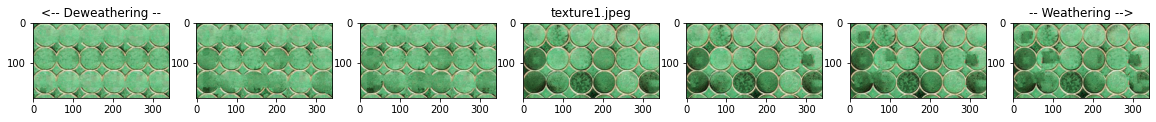

CPU times: user 13min 12s, sys: 11.5 s, total: 13min 23s
Wall time: 13min 4s


In [61]:
%%time
# imgPaths = ['../images/' + x for x in ['texture0.png', 'texture1.jpeg', 'texture2.jpeg', 'texture3.jpeg', 'texture4.png', 'texture5.jpeg']]
imgPaths = ['../images/' + x for x in ['texture1.jpeg']]
processImages(imgPaths)

Processing texture0.png
Generating Deweathered Image...
Done!....
Generating Deweathered Image...
Done!....
Generating Deweathered Image...
Done!....


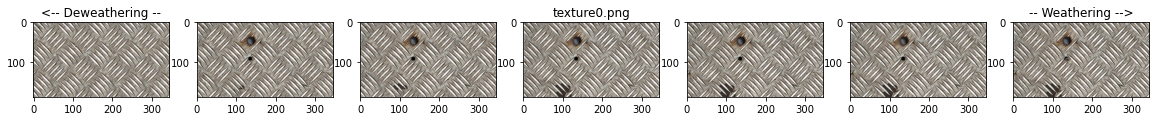

In [99]:
# imgPaths = ['../images/' + x for x in ['texture0.png', 'texture1.jpeg', 'texture2.jpeg', 'texture3.jpeg', 'texture4.png', 'texture5.jpeg']]
imgPaths = ['../images/' + x for x in ['texture0.png']]
processImages(imgPaths)

Processing texture3.png
Generating Deweathered Image...
Done!....
Generating Deweathered Image...
Done!....
Generating Deweathered Image...
Done!....


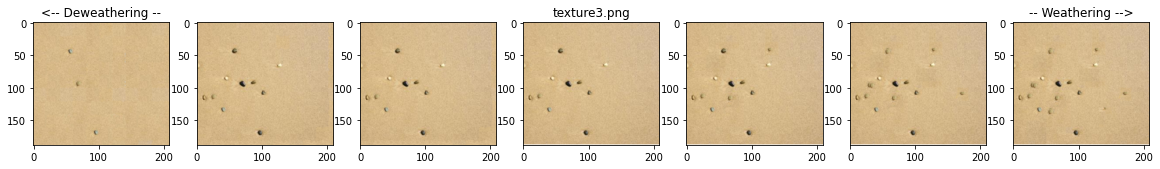

CPU times: user 6min 44s, sys: 7.72 s, total: 6min 52s
Wall time: 6min 41s


In [60]:
%%time
imgPaths = ['../images/' + x for x in ['texture3.png']]
processImages(imgPaths)

Processing texture7.png
Generating Deweathered Image...
Done!....
Generating Deweathered Image...
Done!....
Generating Deweathered Image...
Done!....


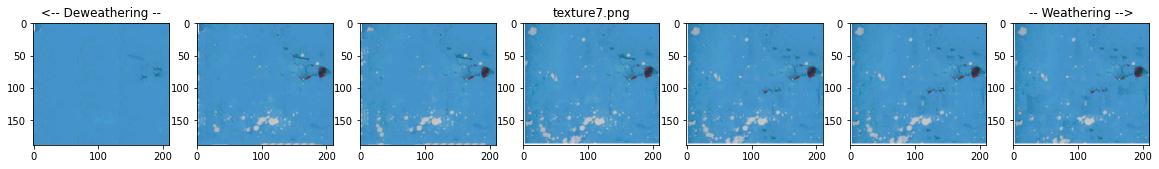

CPU times: user 7min 20s, sys: 8.53 s, total: 7min 28s
Wall time: 7min 13s


In [60]:
%%time
imgPaths = ['../images/' + x for x in ['texture7.png']]
processImages(imgPaths)

In [ ]:
%%time
# MDG
imgPaths = ['../images/' + x for x in ['texture2.png']]
processImages(imgPaths)

In [ ]:
%%time
# Mohsin
imgPaths = ['../images/' + x for x in ['input.png']]
processImages(imgPaths)

In [ ]:
%%time
# Shivansh
imgPaths = ['../images/' + x for x in ['texture4.png']]
processImages(imgPaths)

In [ ]:
%%time
# Mohsin
imgPaths = ['../images/' + x for x in ['texture5.jpeg']]
processImages(imgPaths)

In [ ]:
%%time
# Srivathsan
imgPaths = ['../images/' + x for x in ['texture6.png']]
processImages(imgPaths)

### ----- END -----